
# Non parametric Adaptive Importance Sampling (NAIS)


The objective is to evaluate a probability from the Non parametric Adaptive Importance Sampling (NAIS) technique.

We consider the four-branch function $g : \mathbb{R}^2 \rightarrow \mathbb{R}$ defined by:

\begin{align}\begin{align*}
  g(\vect{X}) = \min \begin{pmatrix}5+0.1(x_1-x_2)^2-\frac{(x_1+x_2)}{\sqrt{2}}\\
  5+0.1(x_1-x_2)^2+\frac{(x_1+x_2)}{\sqrt{2}}\\
  (x_1-x_2)+ \frac{9}{\sqrt{2}}\\
  (x_2-x_1)+ \frac{9}{\sqrt{2}}
  \end{pmatrix}
  \end{align*}\end{align}

and the input random vector $\vect{X} = (X_1, X_2)$ which follows the standard 2-dimensional Normal distribution:

\begin{align}\begin{align*}
  \vect{X} \sim  \mathcal{N}(\mu = [0, 0], \sigma = [1,1], corr = \mat{I}_2)
  \end{align*}\end{align}

We want to evaluate the probability:

\begin{align}\begin{align*}
  p = \mathbb{P} ( g(\vect{X}) \leq 0 )
  \end{align*}\end{align}




First, import the python modules:



In [1]:
import openturns as ot
from openturns.viewer import View
import math

## Create the probabilistic model $Y = g(\vect{X})$



Create the input random vector $\vect{X}$:



In [2]:
X = ot.RandomVector(ot.Normal(2))

Create the function $g$ from a :class:`~openturns.PythonFunction`:



In [3]:
def fourBranch(x):
    x1 = x[0]
    x2 = x[1]

    g1 = 5 + 0.1 * (x1 - x2) ** 2 - (x1 + x2) / math.sqrt(2)
    g2 = 5 + 0.1 * (x1 - x2) ** 2 + (x1 + x2) / math.sqrt(2)
    g3 = (x1 - x2) + 9 / math.sqrt(2)
    g4 = (x2 - x1) + 9 / math.sqrt(2)

    return [min((g1, g2, g3, g4))]


g = ot.PythonFunction(2, 1, fourBranch)

Draw the function $g$ to help to understand the shape of the limit state function:



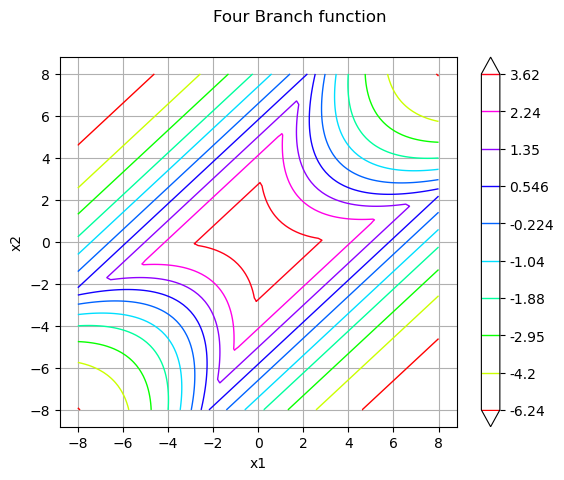

In [4]:
graph = ot.Graph("Four Branch function", "x1", "x2", True, "upper right")
drawfunction = g.draw([-8] * 2, [8] * 2, [100] * 2)
graph.add(drawfunction)
view = View(graph)

In order to be able to get the NAIS samples used in the algorithm, it is necessary to transform the :class:`~openturns.PythonFunction` into a :class:`~openturns.MemoizeFunction`:



In [5]:
g = ot.MemoizeFunction(g)

Create the output random vector $Y = g(\vect{X})$:



In [6]:
Y = ot.CompositeRandomVector(g, X)

## Create the event $\{ Y = g(\vect{X}) \leq 0 \}$



In [7]:
threshold = 0.0
myEvent = ot.ThresholdEvent(Y, ot.Less(), threshold)

## Evaluate the probability with the NAIS technique



In [8]:
quantileLevel = 0.1
algo = ot.NAIS(myEvent, quantileLevel)

In order to get all the inputs and outputs that realize the event, you have to mention it now:



In [9]:
algo.setKeepSample(True)

Now you can run the algorithm.



In [10]:
algo.run()
result = algo.getResult()
proba = result.getProbabilityEstimate()
print("Proba NAIS = ", proba)
print("Current coefficient of variation = ", result.getCoefficientOfVariation())

Proba NAIS =  7.05355539857732e-06
Current coefficient of variation =  0.09506021147598277


In [33]:
output_sample = result.getAuxiliaryDistribution().getSample(100)

In [42]:
import numpy as np

In [30]:
result.getAuxiliaryDistribution().computePDF((1,2))

0.0006360750864497097

In [32]:
aux_dist = result.getAuxiliaryDistribution()

In [ ]:
def sample_IS(aux_dist, n_run):
    """
    Run a simulation of size n_run.
    Sampling done along draw_g 
    Returns the output of the function g
    """
    # Draw delays for all simulations in a vectorized manner
    X = aux_dist.getSample(n_run)

    return X, g(X)

The length of the confidence interval of level $95\%$ is:



In [ ]:
length95 = result.getConfidenceLength()
print("Confidence length (0.95) = ", result.getConfidenceLength())

which enables to build the confidence interval:



In [ ]:
print(
    "Confidence interval (0.95) = [",
    proba - length95 / 2,
    ", ",
    proba + length95 / 2,
    "]",
)

You can also get the successive thresholds used by the algorithm:



In [ ]:
levels = algo.getThresholdPerStep()
print("Levels of g = ", levels)

## Draw the NAIS samples used by the algorithm



You can get the number $N_s$ of steps with:



In [ ]:
Ns = algo.getStepsNumber()
print("Number of steps= ", Ns)

Get all the inputs where $g$ was evaluated at each step



In [ ]:
list_subSamples = list()
for step in range(Ns):
    list_subSamples.append(algo.getInputSample(step))

The following graph draws each NAIS sample and the frontier $g(x_1, x_2) = l_i$ where $l_i$ is the threshold at the step $i$:



In [ ]:
graph = ot.Graph()
graph.setAxes(True)
graph.setGrid(True)
graph.setTitle("NAIS sampling: samples")
graph.setXTitle(r"$x_1$")
graph.setYTitle(r"$x_2$")
graph.setLegendPosition("lower left")

Add all the NAIS samples:



In [ ]:
for i in range(Ns):
    cloud = ot.Cloud(list_subSamples[i])
    # cloud.setPointStyle("dot")
    graph.add(cloud)
col = graph.getColors()

Add the frontiers $g(x_1, x_2) = l_i$ where $l_i$ is the threshold at the step $i$:



In [ ]:
gIsoLines = g.draw([-5] * 2, [5] * 2, [128] * 2)
dr = gIsoLines.getDrawable(0)
for i, lv in enumerate(levels):
    dr.setLevels([lv])
    dr.setLineStyle("solid")
    dr.setLegend(r"$g(X) = $" + str(round(lv, 2)))
    dr.setLineWidth(3)
    dr.setColor(col[i])
    graph.add(dr)

In [ ]:
_ = View(graph)

## Draw the frontiers only

The following graph enables to understand the progression of the algorithm:



In [ ]:
graph = ot.Graph()
graph.setAxes(True)
graph.setGrid(True)
dr = gIsoLines.getDrawable(0)
for i, lv in enumerate(levels):
    dr.setLevels([lv])
    dr.setLineStyle("solid")
    dr.setLegend(r"$g(X) = $" + str(round(lv, 2)))
    dr.setLineWidth(3)
    graph.add(dr)

graph.setColors(col)
graph.setLegendPosition("lower left")
graph.setTitle("NAIS sampling: thresholds")
graph.setXTitle(r"$x_1$")
graph.setYTitle(r"$x_2$")

_ = View(graph)

## Get all the input and output points that realized the event
The following lines are possible only if you have mentioned that you wanted to keep samples with the method *algo.setKeepSample(True)*



In [ ]:
select = ot.NAIS.EVENT1  # points that realize the event
step = Ns - 1  # get the working sample from last iteration
inputEventSample = algo.getInputSample(step, select)
outputEventSample = algo.getOutputSample(step, select)
print("Number of event realizations = ", inputEventSample.getSize())

Draw them! They are all in the event space.



In [ ]:
graph = ot.Graph()
graph.setAxes(True)
graph.setGrid(True)
cloud = ot.Cloud(inputEventSample)
cloud.setPointStyle("bullet")
graph.add(cloud)
gIsoLines = g.draw([-5] * 2, [5] * 2, [1000] * 2)
dr = gIsoLines.getDrawable(0)
dr.setLevels([0.0])
dr.setColor("red")
graph.add(dr)
_ = View(graph)

View.ShowAll()